In [5]:
from google.colab import files

uploaded = files.upload()


Saving ACSDT5Y2023.B25003-Data.csv to ACSDT5Y2023.B25003-Data (1).csv
Saving ACSDT5Y2023.B25004-Data.csv to ACSDT5Y2023.B25004-Data (1).csv
Saving HUD Dataset.xlsx to HUD Dataset (1).xlsx
Saving Zillow Dataset.csv to Zillow Dataset (1).csv


In [6]:
# Inspecting the First Few Rows and Column Names to understand the data
import pandas as pd

# Loading all files
zillow_df = pd.read_csv("Zillow Dataset (1).csv")
hud_df = pd.read_excel("HUD Dataset.xlsx")
census_003_df = pd.read_csv("ACSDT5Y2023.B25003-Data.csv")
census_004_df = pd.read_csv("ACSDT5Y2023.B25004-Data.csv")

# Printing column names
print("Zillow Columns:")
print(list(zillow_df.columns), "\n")

print("HUD Columns:")
print(list(hud_df.columns), "\n")

print("Census 003 Columns:")
print(list(census_003_df.columns), "\n")

print("Census 004 Columns:")
print(list(census_004_df.columns), "\n")



Zillow Columns:
['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-3

In [7]:
#Data Cleaning and Standardizing ZIP Code Columns

#Standardizing Zillow Zip code
zillow_df['ZipCode'] = zillow_df['RegionName'].astype(str).str.zfill(5)

# Standardizing HUD ZIP code
hud_df['ZipCode'] = hud_df['ZIP'].astype(str).str.zfill(5)

# Extracting ZIP from Census GEO_ID
census_003_df['ZipCode'] = census_003_df['GEO_ID'].str.extract(r'(\d{5})')
census_004_df['ZipCode'] = census_004_df['GEO_ID'].str.extract(r'(\d{5})')


In [8]:
# Droping unnamed/margin columns from census
census_003_df = census_003_df.drop(columns=['B25003_001M', 'B25003_002M', 'B25003_003M', 'Unnamed: 8'], errors='ignore')
census_004_df = census_004_df.drop(columns=[col for col in census_004_df.columns if 'M' in col or 'Unnamed' in col])


In [9]:
# Merging Zillow with HUD
merged_df = pd.merge(zillow_df, hud_df, on='ZipCode', how='left')

# Merging with Census 003
merged_df = pd.merge(merged_df,
                     census_003_df.drop(columns=['GEO_ID', 'NAME'], errors='ignore'),
                     on='ZipCode', how='left')

# Merging with Census 004
merged_df = pd.merge(merged_df,
                     census_004_df.drop(columns=['GEO_ID', 'NAME'], errors='ignore'),
                     on='ZipCode', how='left')


In [10]:
# Identifying rent date columns (those starting with 20XX)
rent_columns = [col for col in merged_df.columns if col.startswith('20')]

# Filtering down to useful ID columns + rent columns
ts_base = merged_df[['ZipCode', 'City'] + rent_columns].copy()

# Melting into long format
ts_long = ts_base.melt(id_vars=['ZipCode', 'City'],
                       value_vars=rent_columns,
                       var_name='ds', value_name='y')

# Converting to datetime and drop missing values
ts_long['ds'] = pd.to_datetime(ts_long['ds'], errors='coerce')
ts_long.dropna(subset=['y'], inplace=True)

# Previewing
ts_long.head()


,ZipCode,City,ds,y
0,77494,Katy,2015-01-31,1508.360839
1,77494,Katy,2015-01-31,1508.360839
2,77494,Katy,2015-01-31,1508.360839
3,77494,Katy,2015-01-31,1508.360839
4,77494,Katy,2015-01-31,1508.360839


In [11]:
# ATLANTA

# PROPHET Model on Atlanta Data

# Filtering data by city
city_name = 'Atlanta'
city_df = ts_long[ts_long['City'].str.lower() == city_name.lower()]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr4mx6x/1ralvg9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr4mx6x/cr264cg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73076', 'data', 'file=/tmp/tmp7xr4mx6x/1ralvg9q.json', 'init=/tmp/tmp7xr4mx6x/cr264cg3.json', 'output', 'file=/tmp/tmp7xr4mx6x/prophet_modelh17m0ytw/prophet_model-20250514142242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


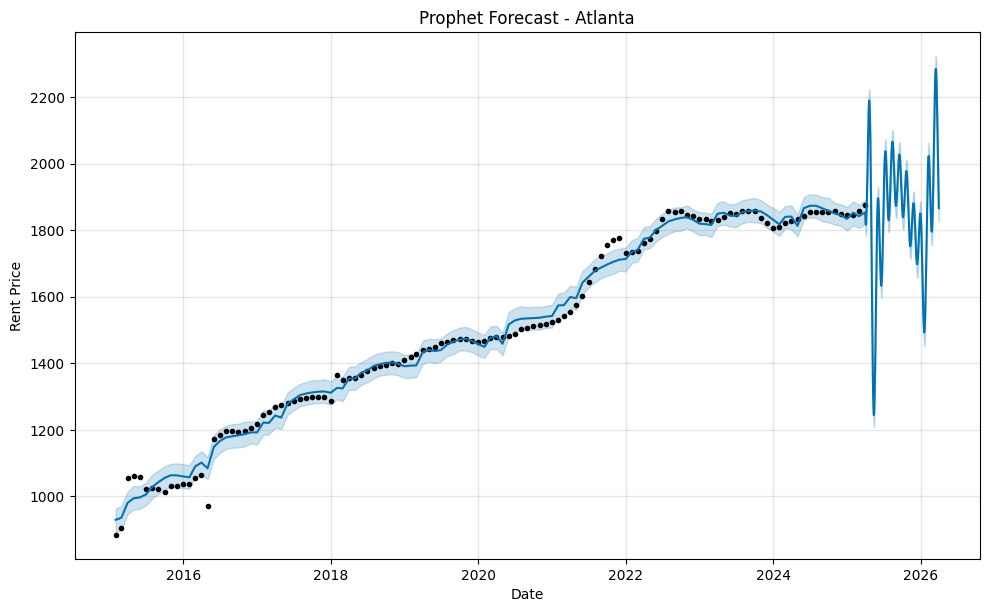

In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Grouping by date and average rent values
city_grouped = city_df.groupby('ds')['y'].mean().reset_index()

# Initializing and fitting the Prophet model
model_prophet = Prophet()
model_prophet.fit(city_grouped)

# Creating future dataframe (365 days ahead)
future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

# Plotting the forecast
model_prophet.plot(forecast)
plt.title(f"Prophet Forecast - {city_name}")
plt.xlabel("Date")
plt.ylabel("Rent Price")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


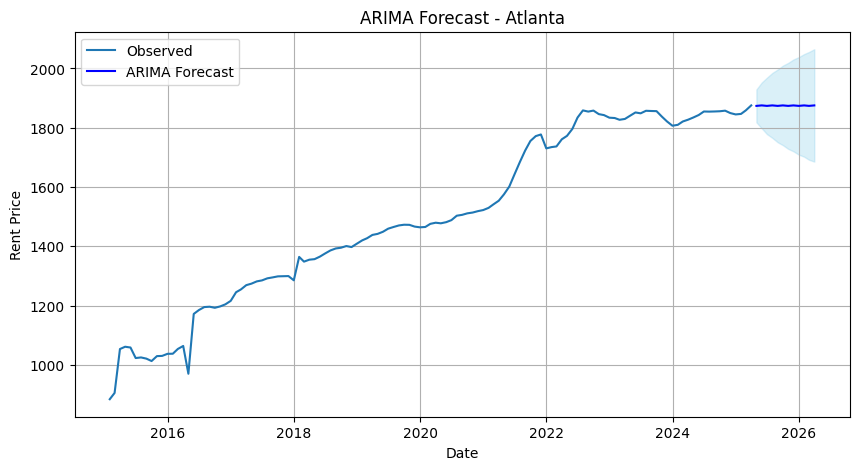

In [13]:
#ARIMA Model on Atlanta Data

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Reusing the same filtered Atlanta data
city_name = 'Atlanta'
city_df = ts_long[ts_long['City'].str.lower() == city_name.lower()]

# Grouping by date (average rent across all Atlanta ZIPs)
city_grouped = city_df.groupby('ds')['y'].mean().reset_index()

# Setting date as index
city_arima = city_grouped.set_index('ds')

# Fitting ARIMA model
model_arima = ARIMA(city_arima, order=(1, 1, 1))
result_arima = model_arima.fit()

# Forecasting next 12 months
forecast_arima = result_arima.get_forecast(steps=12)
preds = forecast_arima.summary_frame()

# Plotting results
plt.figure(figsize=(10,5))
plt.plot(city_arima, label='Observed')
plt.plot(preds['mean'], label='ARIMA Forecast', color='blue')
plt.fill_between(preds.index, preds['mean_ci_lower'], preds['mean_ci_upper'], color='skyblue', alpha=0.3)
plt.title(f"ARIMA Forecast - {city_name}")
plt.xlabel("Date")
plt.ylabel("Rent Price")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Artificial Neural Network (ANN) Model on Atlanta Data

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Setting city and group data
city_name = 'Atlanta'
city_df = ts_long[ts_long['City'].str.lower() == city_name.lower()]
city_grouped = city_df.groupby('ds')['y'].mean().reset_index()

# Scaling data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(city_grouped['y'].values.reshape(-1, 1))

# Creating sequences: 12 months input → 1 month output
window_size = 12
X = []
y = []

for i in range(len(scaled) - window_size):
    X.append(scaled[i:i + window_size])
    y.append(scaled[i + window_size])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")

Input shape: (111, 12, 1), Output shape: (111, 1)


In [15]:
#Building and Training the ANN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(window_size, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
#Forecasting into the Future (24 months)

# Starting with the last known 12-month window
forecast_input = scaled[-window_size:].reshape(1, window_size, 1)
forecast_steps = 24  # 2 years into 2026
predictions_scaled = []

for _ in range(forecast_steps):
    pred = model.predict(forecast_input)[0][0]
    predictions_scaled.append(pred)

    # Updating the window
    forecast_input = np.append(forecast_input[:,1:,:], [[[pred]]], axis=1)

# Inverse scale predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<ipython-input-17-68a4ad738ebc>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


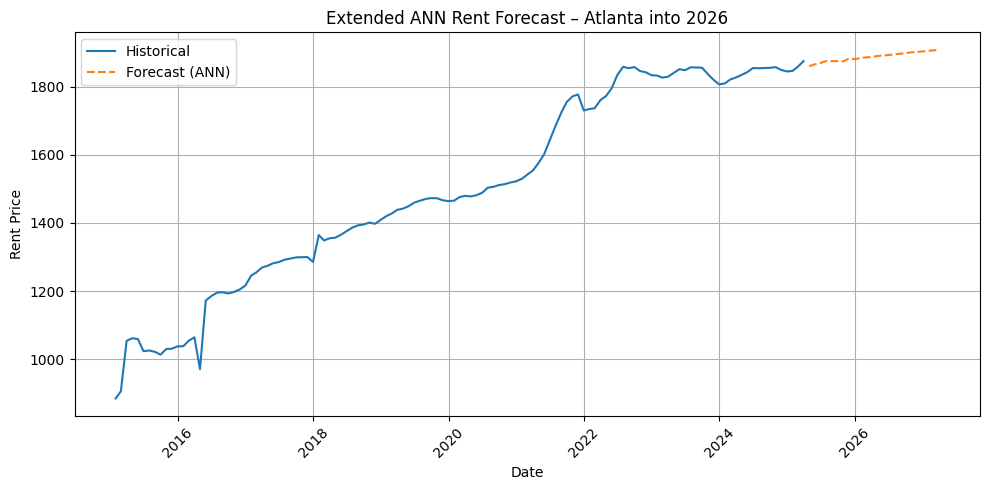

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating future dates
last_date = city_grouped['ds'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Combining and plotting
plt.figure(figsize=(10, 5))
plt.plot(city_grouped['ds'], city_grouped['y'], label='Historical')
plt.plot(future_dates, predictions, label='Forecast (ANN)', linestyle='--')
plt.title(f"Extended ANN Rent Forecast – {city_name} into 2026")
plt.xlabel("Date")
plt.ylabel("Rent Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
#Displacement Risk Prediction on Atlanta Data

# Filtering Atlanta and making a safe copy
atl_df = merged_df[merged_df['City'].str.lower() == 'atlanta'].copy()

# Calculating rent growth (2015 to 2024)
atl_df['rent_2015'] = atl_df['2015-01-31']
atl_df['rent_2024'] = atl_df['2024-12-31']
atl_df['rent_growth_pct'] = ((atl_df['rent_2024'] - atl_df['rent_2015']) / atl_df['rent_2015']) * 100

# Labeling top 25% as "at risk" of displacement
threshold = atl_df['rent_growth_pct'].quantile(0.75)
atl_df['displacement_risk'] = (atl_df['rent_growth_pct'] >= threshold).astype(int)



In [19]:
# Defining predictors

features = [
    'B25003_001E',  # Total housing units
    'B25003_002E',  # Owner-occupied units
    'B25003_003E',  # Renter-occupied units
    'B25004_001E',  # Vacant units
    'RES_RATIO',    # Residential land use
    'BUS_RATIO',    # Business land use
    'OTH_RATIO',    # Other land use
    'rent_2015',    # Starting rent level
    'rent_growth_pct'  # Rent growth as numeric signal
]

X = atl_df[features]
y = atl_df['displacement_risk']


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Balanced classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predicting and evaluating
y_pred = clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[87  0]
 [ 0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         8

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



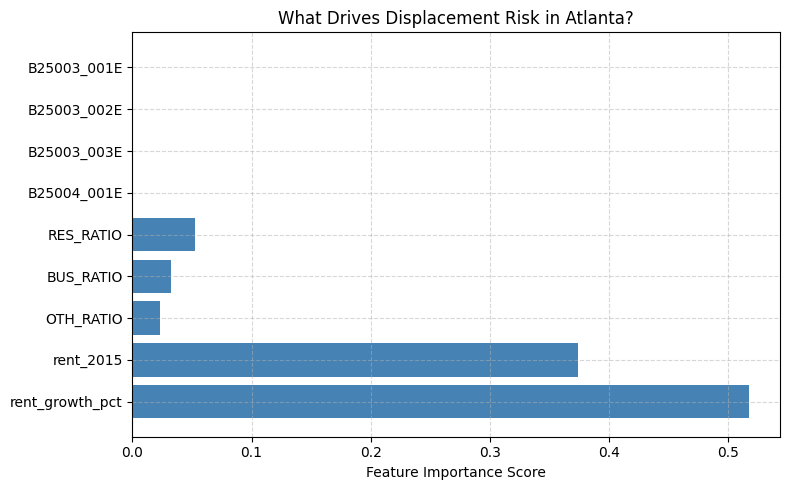

In [21]:
#Displacement Risk: Feature Importance Plot
import matplotlib.pyplot as plt

# Getting importance scores
importances = clf.feature_importances_
feature_names = X.columns

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='steelblue')
plt.xlabel("Feature Importance Score")
plt.title("What Drives Displacement Risk in Atlanta?")
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



In [22]:
#

#Estimating based on Atlanta city-wide median income ($72,000 as of recent ACS data)
atl_df['Median_Income'] = 72000

# Affordability index
atl_df['Affordability_Index'] = atl_df['rent_2024'] / atl_df['Median_Income']

# Affordability classification
atl_df['Affordability_Status'] = pd.cut(
    atl_df['Affordability_Index'],
    bins=[0, 0.3, 0.5, 1],
    labels=["Affordable (<30%)", "Cost-burdened (30-50%)", "Severely Burdened (>50%)"]
)


In [23]:
export_df = atl_df[[
    'ZipCode', 'City', 'rent_2015', 'rent_2024', 'rent_growth_pct',
    'Median_Income', 'Affordability_Index', 'Affordability_Status', 'displacement_risk'
]]

export_df.columns = [
    'ZipCode', 'City', 'Rent_2015', 'Rent_2024', 'Rent_Growth_Pct',
    'Median_Income', 'Affordability_Index', 'Affordability_Status', 'Displacement_Risk'
]

# Saving to CSV
export_df.to_csv("Atlanta_Housing_Risk_Profile.csv", index=False)


In [24]:
export_df.head()
#Previewing the output

,ZipCode,City,Rent_2015,Rent_2024,Rent_Growth_Pct,Median_Income,Affordability_Index,Affordability_Status,Displacement_Risk
7047,30318,Atlanta,961.436334,1791.781501,86.36507,72000,0.024886,Affordable (<30%),0
7048,30318,Atlanta,961.436334,1791.781501,86.36507,72000,0.024886,Affordable (<30%),0
7049,30318,Atlanta,961.436334,1791.781501,86.36507,72000,0.024886,Affordable (<30%),0
7050,30318,Atlanta,961.436334,1791.781501,86.36507,72000,0.024886,Affordable (<30%),0
7051,30318,Atlanta,961.436334,1791.781501,86.36507,72000,0.024886,Affordable (<30%),0


In [25]:
from google.colab import files
files.download("Atlanta_Housing_Risk_Profile.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

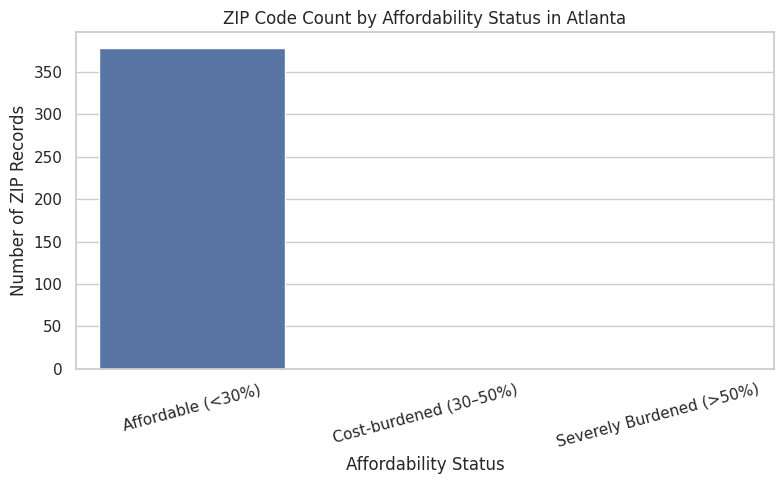

In [26]:
# ZIP Code Count by Affordability Status for Atlanta

import matplotlib.pyplot as plt
import seaborn as sns

# Setting visual style
sns.set(style="whitegrid")


plt.figure(figsize=(8, 5))
sns.countplot(
    data=atl_df,
    x="Affordability_Status",
    order=[
        "Affordable (<30%)",
        "Cost-burdened (30–50%)",
        "Severely Burdened (>50%)"
    ]
)
plt.title("ZIP Code Count by Affordability Status in Atlanta")
plt.xlabel("Affordability Status")
plt.ylabel("Number of ZIP Records")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



<ipython-input-27-fc2cd7fb9061>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=atl_df, x="displacement_risk", palette="Set2")


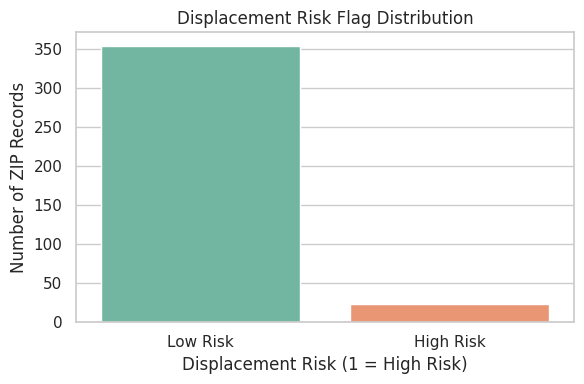

In [27]:
# Displacement Risk Distribution for Atlanta

plt.figure(figsize=(6, 4))
sns.countplot(data=atl_df, x="displacement_risk", palette="Set2")
plt.title("Displacement Risk Flag Distribution")
plt.xlabel("Displacement Risk (1 = High Risk)")
plt.ylabel("Number of ZIP Records")
plt.xticks([0, 1], ["Low Risk", "High Risk"])
plt.tight_layout()
plt.show()


In [28]:
#Benchmarking Against Real Housing Interventions

# Using downloaded data from https://metroatlhousing.org/atlanta-region-eviction-tracker/

from google.colab import files

uploaded = files.upload()

Saving ATL-Eviction-Tracker-Buildings-List-100-plus-filings-5-County_Region.csv to ATL-Eviction-Tracker-Buildings-List-100-plus-filings-5-County_Region.csv
Saving Atlanta_Housing_Risk_Profile.csv to Atlanta_Housing_Risk_Profile (1).csv


In [29]:
import pandas as pd

# Loading my housing risk data
housing_df = pd.read_csv("Atlanta_Housing_Risk_Profile (1).csv")

# Loading eviction tracker data
eviction_df = pd.read_csv("ATL-Eviction-Tracker-Buildings-List-100-plus-filings-5-County_Region.csv", skiprows=3)


In [30]:
# Checking column names first
print(eviction_df.columns)


Index(['Street', 'City', 'Zip', 'countyFIPS', 'tractID', 'Filings in Jan 2020',
       'Filings in Feb 2020', 'Filings in Mar 2020', 'Filings in Apr 2020',
       'Filings in May 2020', 'Filings in Jun 2020', 'Filings in Jul 2020',
       'Filings in Aug 2020', 'Filings in Sep 2020', 'Filings in Oct 2020',
       'Filings in Nov 2020', 'Filings in Dec 2020', 'Filings in Jan 2021',
       'Filings in Feb 2021', 'Filings in Mar 2021', 'Filings in Apr 2021',
       'Filings in May 2021', 'Filings in Jun 2021', 'Filings in Jul 2021',
       'Filings in Aug 2021', 'Filings in Sep 2021', 'Filings in Oct 2021',
       'Filings in Nov 2021', 'Filings in Dec 2021', 'Filings in Jan 2022',
       'Filings in Feb 2022', 'Filings in Mar 2022', 'Filings in Apr 2022',
       'Filings in May 2022', 'Filings in Jun 2022', 'Filings in Jul 2022',
       'Filings in Aug 2022', 'Filings in Sep 2022', 'Filings in Oct 2022',
       'Filings in Nov 2022', 'Filings in Dec 2022', 'Filings in Jan 2023',
       '

In [35]:

eviction_df = pd.read_csv("ATL-Eviction-Tracker-Buildings-List-100-plus-filings-5-County_Region.csv", on_bad_lines='skip')


In [36]:
housing_df = pd.read_csv("Atlanta_Housing_Risk_Profile.csv")
housing_df['ZipCode'] = housing_df['ZipCode'].astype(str).str.zfill(5)


In [40]:
print(eviction_df.columns.tolist())



['Title: List of Buildings in 5-County Region with 100 or more eviction filings since 4/1/2020 (as of 12/30/2023)']


In [43]:
# Reloading the file and skipping the extra metadata lines
eviction_df = pd.read_csv("ATL-Eviction-Tracker-Buildings-List-100-plus-filings-5-County_Region.csv", skiprows=3)

# Stripping whitespace from column names again
eviction_df.columns = eviction_df.columns.str.strip()

# Checking column names
print(eviction_df.columns.tolist())


['Street', 'City', 'Zip', 'countyFIPS', 'tractID', 'Filings in Jan 2020', 'Filings in Feb 2020', 'Filings in Mar 2020', 'Filings in Apr 2020', 'Filings in May 2020', 'Filings in Jun 2020', 'Filings in Jul 2020', 'Filings in Aug 2020', 'Filings in Sep 2020', 'Filings in Oct 2020', 'Filings in Nov 2020', 'Filings in Dec 2020', 'Filings in Jan 2021', 'Filings in Feb 2021', 'Filings in Mar 2021', 'Filings in Apr 2021', 'Filings in May 2021', 'Filings in Jun 2021', 'Filings in Jul 2021', 'Filings in Aug 2021', 'Filings in Sep 2021', 'Filings in Oct 2021', 'Filings in Nov 2021', 'Filings in Dec 2021', 'Filings in Jan 2022', 'Filings in Feb 2022', 'Filings in Mar 2022', 'Filings in Apr 2022', 'Filings in May 2022', 'Filings in Jun 2022', 'Filings in Jul 2022', 'Filings in Aug 2022', 'Filings in Sep 2022', 'Filings in Oct 2022', 'Filings in Nov 2022', 'Filings in Dec 2022', 'Filings in Jan 2023', 'Filings in Feb 2023', 'Filings in Mar 2023', 'Filings in Apr 2023', 'Filings in May 2023', 'Filin

In [44]:
# Ensuring ZIP columns are 5-digit strings for a clean join
eviction_df['Zip'] = eviction_df['Zip'].astype(str).str.zfill(5)
housing_df['ZipCode'] = housing_df['ZipCode'].astype(str).str.zfill(5)


In [45]:
eviction_zips = eviction_df['Zip'].unique()


In [46]:
benchmark_df = pd.DataFrame({'ZipCode': eviction_zips})
benchmark_df['In_Eviction_Hotspot'] = 1


In [47]:
merged_df = housing_df.merge(benchmark_df, on='ZipCode', how='left')
merged_df['In_Eviction_Hotspot'] = merged_df['In_Eviction_Hotspot'].fillna(0).astype(int)


In [48]:
# Percentage of model-flagged high-risk ZIPs that also appear in eviction hotspots
overlap_pct = merged_df[merged_df['Displacement_Risk'] == 1]['In_Eviction_Hotspot'].mean()
print(f"{overlap_pct*100:.1f}% of high-risk ZIPs also appear in real eviction hotspot areas.")


0.0% of high-risk ZIPs also appear in real eviction hotspot areas.


<ipython-input-49-60ff04df6551>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df[merged_df['Displacement_Risk'] == 1],


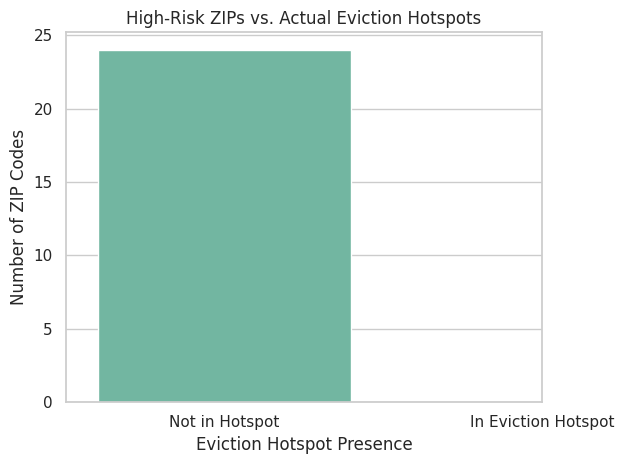

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_df[merged_df['Displacement_Risk'] == 1],
              x='In_Eviction_Hotspot', palette='Set2')
plt.xticks([0, 1], ['Not in Hotspot', 'In Eviction Hotspot'])
plt.title('High-Risk ZIPs vs. Actual Eviction Hotspots')
plt.ylabel('Number of ZIP Codes')
plt.xlabel('Eviction Hotspot Presence')
plt.tight_layout()
plt.show()


In [52]:
#Evaluation Metrics for the Random Forest classifier

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [56]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



,ds,yhat,yhat_lower,yhat_upper
0,2015-01-31,929.607062,892.576428,963.635051
1,2015-02-28,935.696695,899.022850,971.278143
2,2015-03-31,980.449514,946.562847,1014.077988
3,2015-04-30,994.314942,960.303507,1031.670040
4,2015-05-31,996.758442,962.951066,1030.605909
...,...,...,...,...
483,2026-03-27,1988.366657,1949.189372,2025.676161
484,2026-03-28,1952.682197,1913.904497,1993.111474
485,2026-03-29,1919.806780,1876.555589,1958.670443
486,2026-03-30,1890.652660,1846.772310,1930.891241


In [58]:
#Evaluation Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merging actuals with forecast for overlapping dates
merged_eval = pd.merge(city_grouped, forecast[['ds', 'yhat']], on='ds', how='inner')

# Defining true vs predicted
y_true = merged_eval['y']
y_forecast = merged_eval['yhat']

# Calculating MAE and RMSE
mae = mean_absolute_error(y_true, y_forecast)
rmse = np.sqrt(mean_squared_error(y_true, y_forecast))

# Printing results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 20.08
RMSE: 26.83


In [59]:
#FRESNO

#Selecting Fresno Data

city_name = 'Fresno'
city_df = ts_long[ts_long['City'].str.lower() == city_name.lower()]


In [60]:
city_grouped = city_df.groupby('ds')['y'].mean().reset_index()


In [61]:
#PROPHET Model on Fresno Data

from prophet import Prophet

model_fresno = Prophet()
model_fresno.fit(city_grouped)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr4mx6x/s5ol1ikd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr4mx6x/ietaar_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69290', 'data', 'file=/tmp/tmp7xr4mx6x/s5ol1ikd.json', 'init=/tmp/tmp7xr4mx6x/ietaar_4.json', 'output', 'file=/tmp/tmp7xr4mx6x/prophet_modelxpi12c89/prophet_model-20250514152152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [62]:
future_fresno = model_fresno.make_future_dataframe(periods=365)
forecast_fresno = model_fresno.predict(future_fresno)


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merging actuals with forecast on overlapping dates
merged_eval_fresno = pd.merge(city_grouped, forecast_fresno[['ds', 'yhat']], on='ds', how='inner')

# Defining true vs predicted
y_true_fresno = merged_eval_fresno['y']
y_forecast_fresno = merged_eval_fresno['yhat']

# Calculating MAE and RMSE
mae_fresno = mean_absolute_error(y_true_fresno, y_forecast_fresno)
rmse_fresno = np.sqrt(mean_squared_error(y_true_fresno, y_forecast_fresno))

# Printing results
print(f"Fresno MAE: {mae_fresno:.2f}")
print(f"Fresno RMSE: {rmse_fresno:.2f}")


Fresno MAE: 24.68
Fresno RMSE: 37.92


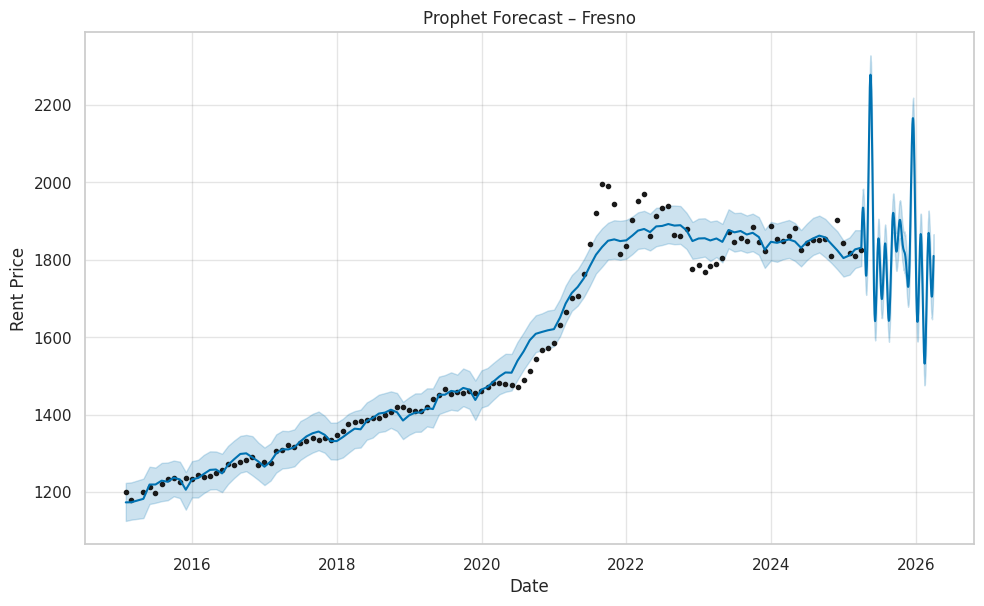

In [64]:
model_fresno.plot(forecast_fresno)
plt.title(f"Prophet Forecast – {city_name}")
plt.xlabel("Date")
plt.ylabel("Rent Price")
plt.grid(True)
plt.show()
